In [0]:
import jax.numpy as np
from jax import grad, jit, vmap, jacrev
from jax import random
from jax import ops
import matplotlib.pyplot as plt
import numpy as onp
from jax import device_put

In [0]:
tsteps = 2000
batch_tsteps = 10
num_batches = 10
dt = 25.0/tsteps
reg_param = 0.0

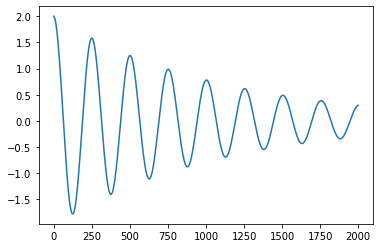

In [3]:
# Generating dynamical system data
def true_forward_solver(state,ds_mat):
    i0 = state + dt*np.matmul(state,ds_mat)
    return i0, np.matmul(i0,ds_mat)

true_forward_solver = jit(true_forward_solver) # Just in time compile

# State (z), rhs saver (f)
state_len = 2
true_state_array = np.zeros(shape=(tsteps,state_len)) # No double in Jax and mutable numpy
true_rhs_array = np.zeros(shape=(tsteps,state_len)) # No double in Jax and mutable numpy
# Time array - fixed
time_array = dt*np.arange(tsteps)

# DS definition
init_state = np.asarray([[2.0,0.0]])
ds_mat = np.asarray([[-0.1, 2.0], [-2.0, -0.1]])

true_state_array = ops.index_update(true_state_array, ops.index[0:1,:], init_state)
true_rhs_array = ops.index_update(true_rhs_array, ops.index[0:1,:], np.matmul(init_state,ds_mat))


for i in range(1,tsteps):
    state_new, rhs_new = true_forward_solver(init_state,ds_mat)

    true_state_array = ops.index_update(true_state_array, ops.index[i:i+1,:], state_new)
    true_rhs_array = ops.index_update(true_rhs_array, ops.index[i:i+1,:], np.matmul(init_state,ds_mat))
    init_state = ops.index_update(init_state, ops.index[:], state_new)


plt.figure()
plt.plot(true_state_array[:,0])
plt.show()

In [0]:
# Define neural network parameters - simple 1-layer fc,ff nn - Xavier initialization
num_neurons = 30
weights_1 = onp.random.randn(state_len,num_neurons)*onp.sqrt(1.0/(state_len+num_neurons)) 
weights_2 = onp.random.randn(num_neurons,state_len)*onp.sqrt(1.0/(state_len+num_neurons))  
bias_1 = onp.random.randn(1,num_neurons)*onp.sqrt(1.0/(num_neurons))
bias_2 = onp.random.randn(1,state_len)*onp.sqrt(1.0/(state_len))
# Flatten (and reshape) parameters for the purpose of autograd
thetas = onp.concatenate((weights_1.flatten(),bias_1.flatten(),weights_2.flatten(),bias_2.flatten()),axis=0)
num_wb = onp.shape(thetas)[0]
thetas = onp.reshape(thetas,newshape=(1,num_wb))

thetas = device_put(thetas) # Put weights on device

# Reshaping indices
w1_idx_end = num_neurons*(state_len) # not inclusive
b1_idx_start = num_neurons*(state_len)
b1_idx_end = num_neurons*(state_len) + num_neurons

w2_idx_start = num_neurons*(state_len) + num_neurons
w2_idx_end = num_neurons*(state_len) + num_neurons + num_neurons*state_len

b2_idx_start = num_neurons*(state_len) + num_neurons + num_neurons*state_len

# Reshaping function for parameters
def theta_reshape(thetas):
    weights_1_flattened = thetas[0,0:w1_idx_end]
    bias_1_flattened = thetas[0,b1_idx_start:b1_idx_end]

    weights_2_flattened = thetas[0,w2_idx_start:w2_idx_end]
    bias_2_flattened = thetas[0,b2_idx_start:]

    weights_1 = np.reshape(weights_1_flattened,(state_len,num_neurons))
    weights_2 = np.reshape(weights_2_flattened,(num_neurons,state_len))

    bias_1 = np.reshape(bias_1_flattened,(1,num_neurons))
    bias_2 = np.reshape(bias_2_flattened,(1,state_len))

    return weights_1, weights_2, bias_1, bias_2

# Simple Feed forward network for RHS calculation
def ffnn(state,weights_1,weights_2,bias_1,bias_2):
    h = np.tanh(np.matmul(state,weights_1)+bias_1)
    return np.matmul(h,weights_2)+bias_2


theta_reshape = jit(theta_reshape) # Just in time compile
ffnn = jit(ffnn) # Just in time compile

In [0]:
# Our ODE integrator - Euler Forward
# Forward model (Neural ODE formulation) - one timestep
def euler_forward(state,weights_1,weights_2,bias_1,bias_2,time):
    # Step 1
    i0 = state + dt*ffnn(state,weights_1,weights_2,bias_1,bias_2)
    # Output for saving state
    f_rhs = ffnn(i0,weights_1,weights_2,bias_1,bias_2)

    return i0, f_rhs

euler_forward = jit(euler_forward) # Just in time compile

In [0]:
# The final loss functions - this is needed for adjoint initial condition calculation
# First as a function of final state (dldz)
def training_loss_state(state,true_state):
    loss = np.sum((state - true_state)**2)
    return loss

training_loss_state = jit(training_loss_state) # Just in time compile

# Its gradient
dldz_func = jit(grad(training_loss_state,0)) # Output is a (1,state_len) array
# Secondly as a function of pvec (a concatenated vector of state,thetas,time)
def training_loss(pvec,true_state):
    _state = np.reshape(pvec[:,:state_len],(1,state_len)) # The state
    _thetas = np.reshape(pvec[:,state_len:-1],(1,num_wb)) # NN Parameters
    _time = np.reshape(pvec[:,-1],(1,1)) # Time
    _weights_1, _weights_2, _bias_1, _bias_2 = theta_reshape(_thetas)
    _output_state, _ = euler_forward(_state,_weights_1,_weights_2, _bias_1, _bias_2,_time)
    loss = np.sum((_output_state - true_state)**2)
    return loss

training_loss = jit(training_loss) # Just in time compile  
# Its gradient
dl_func = jit(grad(training_loss,0)) # Output is a (1,state_len+num_wb+1) array
# Now we define the parameterization (i.e., the rhs of the ODE in terms of an NN - f(z))
def rhs_calculator(pvec):
    _state = np.reshape(pvec[:,:state_len],(1,state_len)) # The state
    _thetas = np.reshape(pvec[:,state_len:-1],(1,num_wb)) # NN Parameters
    _time = np.reshape(pvec[:,-1],(1,1)) # Time    
    _weights_1, _weights_2, _bias_1, _bias_2 = theta_reshape(_thetas)
    rhs = ffnn(_state,_weights_1,_weights_2, _bias_1, _bias_2)
    rhs = rhs.flatten()
    return rhs

rhs_calculator = jit(rhs_calculator) # Just in time compile  
# Calculate Jacobians - dfdz, dfdthetas, dfdt
df_func = jit(jacrev(rhs_calculator)) # Output is a (state_len,1,state_len+num_wb+1) array - must be squeezed as needed
# Adjoint RHS calculation
def adjoint_rhs(a,pvec):
    # Time to calculate Jacobians
    df = np.squeeze(df_func(pvec),axis=1)
    dfdz = df[:,0:state_len]

    dfdthetas = df[:,state_len:-1]
    dfdt = np.reshape(df[:,-1],(state_len,1))

    dfs = np.concatenate((dfdz,dfdthetas,dfdt),axis=1)
    rhs_reverse = np.matmul(a[:,:state_len],dfs)

    return rhs_reverse

adjoint_rhs = jit(adjoint_rhs)

In [0]:
# Neural ODE algorithm - minibatching
def neural_ode(thetas):
    weights_1, weights_2, bias_1, bias_2 = theta_reshape(thetas) # Reshape once for utilization in entire iteration
    batch_state_array = np.zeros(shape=(num_batches,batch_tsteps,state_len),dtype='double') # 
    batch_rhs_array = np.zeros(shape=(num_batches,batch_tsteps,state_len),dtype='double') #
    batch_time_array = np.zeros(shape=(num_batches,batch_tsteps,1),dtype='double') #

    augmented_state = np.zeros(shape=(1,state_len+num_wb+1))
    batch_ids = onp.random.choice(tsteps-batch_tsteps,num_batches)
    batch_ids = device_put(batch_ids)

    # Minibatching within sampled domain
    total_batch_loss = 0.0
    for j in range(num_batches):
        start_id = batch_ids[j]
        end_id = start_id + batch_tsteps

        # batch_state_array[j,0,:] = true_state_array[start_id,:]
        batch_state_array = ops.index_update(batch_state_array, ops.index[j:j+1,0:1,:], true_state_array[start_id,:])


        # batch_rhs_array[j,0,:] = true_rhs_array[start_id,:]
        batch_rhs_array = ops.index_update(batch_rhs_array, ops.index[j:j+1,0:1,:], true_rhs_array[start_id,:])

        # batch_time_array[j,:batch_tsteps] = time_array[start_id:end_id,None]
        batch_time_array = ops.index_update(batch_time_array, ops.index[j:j+1,:batch_tsteps], time_array[start_id:end_id,None])

        # Calculate forward pass - saving results for state and rhs to array - batchwise
        temp_state = batch_state_array[j,0,:]
        for i in range(1,batch_tsteps):
            time = np.reshape(batch_time_array[j,i],newshape=(1,1))
            output_state, output_rhs = euler_forward(temp_state,weights_1,weights_2,bias_1,bias_2,time)  
            
            # batch_state_array[j,i,:] = output_state[:]
            batch_state_array = ops.index_update(batch_state_array, ops.index[j:j+1,i:i+1,:], output_state[:])

            # batch_rhs_array[j,i,:] = output_rhs[:]
            batch_rhs_array = ops.index_update(batch_rhs_array, ops.index[j:j+1,i:i+1,:], output_rhs[:])

            temp_state = output_state

        # Operations at final time step (setting up initial conditions for the adjoint)
        temp_state = batch_state_array[j,-2,:]
        temp_state = np.reshape(temp_state,(1,state_len)) # prefinal state vector
        time = np.reshape(batch_time_array[j,-2],(1,1)) # prefinal time
        pvec = np.concatenate((temp_state,thetas,time),axis=1)

        # Calculate loss related gradients - dldz
        dldz = np.reshape(dldz_func(output_state,true_state_array[end_id-1,:]),(1,state_len))
        # With respect to weights,bias and time
        dl = dl_func(pvec,true_state_array[end_id-1,:])
        dldthetas = onp.reshape(dl[:,state_len:-1],newshape=(1,num_wb))
        # Calculate dl/dt
        dldt = np.matmul(dldz,batch_rhs_array[j,-1,:])
        dldt = np.reshape(dldt,newshape=(1,1))

        # Find batch loss
        total_batch_loss = total_batch_loss + np.sum((output_state-true_state_array[end_id-1,:])**2)

        # Reverse operation (adjoint evolution in backward time)
        _augmented_state = np.concatenate((dldz,dldthetas,dldt),axis=1)
        for i in range(1,batch_tsteps):
            time = np.reshape(batch_time_array[j,-1-i],newshape=(1,1))
            state_now = np.reshape(batch_state_array[j,-1-i,:],newshape=(1,state_len))
            pvec = np.concatenate((state_now,thetas,time),axis=1)

            # Adjoint propagation backward in time
            i0 = _augmented_state + dt*adjoint_rhs(_augmented_state,pvec)
            sub_state = np.reshape(i0[0,:state_len],newshape=(1,state_len))

            _augmented_state = i0
        
        augmented_state = np.add(augmented_state,_augmented_state)
    
    return augmented_state, total_batch_loss

neural_ode = jit(neural_ode)

In [0]:
# Optimization
def rms_prop_optimize(thetas):
    num_epochs = 200
    lr = 0.01
    beta = 0.9
    lr_counter = 0
    exp_gradient = np.zeros(shape=(1,num_wb))
    best_loss = onp.Inf
    loss_list = []
    for epoch in range(num_epochs):
        augmented_state, total_batch_loss = neural_ode(thetas)      
              
        if epoch == 0:
            exp_gradient = (1.0-beta)*(augmented_state[0,state_len:-1]**2)
        else:
            exp_gradient = beta*exp_gradient + (1.0-beta)*(augmented_state[0,state_len:-1]**2)

        thetas = thetas - lr/(np.sqrt(exp_gradient))*(augmented_state[0,state_len:-1])
        lr_counter = lr_counter + 1

        if total_batch_loss<best_loss:
            np.save('Trained_Weights.npy',thetas)
            # visualize(mode='train')
            best_loss = total_batch_loss

        print('iteration: ',epoch,' Loss: ',best_loss)
        loss_list.append(total_batch_loss)
        
        if lr_counter > 100:
            lr = lr*0.9
            lr_counter = 0

    return thetas, loss_list

In [0]:
# Visualization function
def visualize(mode='train'):
    # Visualization fluff here
    fig, ax = plt.subplots(nrows=2,ncols=1)

    ax[0].set_title('Mode 1')
    ax[0].set_ylim(-4.0,4.0)
    ax[1].set_title('Mode 2')
    ax[1].set_ylim(-4.0,4.0)

    t1n1 = ax[0].plot(true_state_array[:,0],label='True')
    t1n2 = ax[1].plot(true_state_array[:,1],label='True')
    predicted_states = forward_model()
    # Visualization of modal evolution
    ln1, = ax[0].plot(predicted_states[:,0],label='ML',color='orange')
    ln2, = ax[1].plot(predicted_states[:,1],label='ML',color='orange')

    plt.legend()
    plt.tight_layout()
    plt.show()


# Forward model
def forward_model():
    thetas = np.load('Trained_Weights.npy')
    weights_1, weights_2, bias_1, bias_2 = theta_reshape(thetas)

    # Calculate forward pass - saving results for state and rhs to array
    pred_state_array = np.zeros(shape=(tsteps,state_len),dtype='double')

    pred_state_array = ops.index_update(pred_state_array, ops.index[0:1,:], true_state_array[0,:])
    temp_state = true_state_array[0,:]
    for i in range(1,tsteps):
        time = np.reshape(time_array[i],(1,1))
        output_state, output_rhs = euler_forward(temp_state,weights_1,weights_2,bias_1,bias_2,time)
        pred_state_array = ops.index_update(pred_state_array, ops.index[i:i+1,:], output_state[:])
        temp_state = output_state

    return pred_state_array

In [10]:
import time

start_time = time.time()
thetas_optimal, loss_list = rms_prop_optimize(thetas)
print('Total_time_taken:',time.time()-start_time)

np.save('Trained_Weights.npy',thetas_optimal)

/usr/local/lib/python3.6/dist-packages/jax/lax/lax.py:4578: UserWarning: Explicitly requested dtype double requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


iteration:  0  Loss:  0.73724437
iteration:  1  Loss:  0.53621167
iteration:  2  Loss:  0.41269293
iteration:  3  Loss:  0.31922403
iteration:  4  Loss:  0.24565884
iteration:  5  Loss:  0.18742542
iteration:  6  Loss:  0.14157689
iteration:  7  Loss:  0.105817676
iteration:  8  Loss:  0.07823747
iteration:  9  Loss:  0.057220656
iteration:  10  Loss:  0.041404217
iteration:  11  Loss:  0.029645607
iteration:  12  Loss:  0.021005502
iteration:  13  Loss:  0.014728169
iteration:  14  Loss:  0.010222637
iteration:  15  Loss:  0.007034554
iteration:  16  Loss:  0.0048325686
iteration:  17  Loss:  0.0034078665
iteration:  18  Loss:  0.0027313998
iteration:  19  Loss:  0.0024525223
iteration:  20  Loss:  0.001975395
iteration:  21  Loss:  0.0014193471
iteration:  22  Loss:  0.0010770496
iteration:  23  Loss:  0.00090577384
iteration:  24  Loss:  0.0008400745
iteration:  25  Loss:  0.0008400745
iteration:  26  Loss:  0.0008400745
iteration:  27  Loss:  0.0008400745
iteration:  28  Loss:  0.0

In [11]:
start_time = time.time()
thetas_optimal, loss_list = rms_prop_optimize(thetas)
print('Total_time_taken with jit:',time.time()-start_time)

np.save('Trained_Weights.npy',thetas_optimal)

iteration:  0  Loss:  0.73724437
iteration:  1  Loss:  0.53621167
iteration:  2  Loss:  0.41269293
iteration:  3  Loss:  0.31922403
iteration:  4  Loss:  0.24565884
iteration:  5  Loss:  0.18742542
iteration:  6  Loss:  0.14157689
iteration:  7  Loss:  0.105817676
iteration:  8  Loss:  0.07823747
iteration:  9  Loss:  0.057220656
iteration:  10  Loss:  0.041404217
iteration:  11  Loss:  0.029645607
iteration:  12  Loss:  0.021005502
iteration:  13  Loss:  0.014728169
iteration:  14  Loss:  0.010222637
iteration:  15  Loss:  0.007034554
iteration:  16  Loss:  0.0048325686
iteration:  17  Loss:  0.0034078665
iteration:  18  Loss:  0.0027313998
iteration:  19  Loss:  0.0024525223
iteration:  20  Loss:  0.001975395
iteration:  21  Loss:  0.0014193471
iteration:  22  Loss:  0.0010770496
iteration:  23  Loss:  0.00090577384
iteration:  24  Loss:  0.0008400745
iteration:  25  Loss:  0.0008400745
iteration:  26  Loss:  0.0008400745
iteration:  27  Loss:  0.0008400745
iteration:  28  Loss:  0.0